<div align='left'><font size="6" color="#FFA500">Principal Component Analysis (PCA) in Python</font></div>

<hr>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1IqJ5OsA3gtJz49tfOHJ2N78zI1hvY_r3?usp=sharing)

What is called "Pee-See-Ay"?

PCA is a very common technique for dimensionality reduction. The idea behind it is very simple:
* Identify a Hyperplane that lies closest to the data
* Project the data onto the hyperplane.

![](./Q7HIP.gif)

[Projecting 2D-data to a line (PCA](https://i.stack.imgur.com/Q7HIP.gif)

However, it is important to choose the right hyperplane so that when the data is projected onto it, it the maximum amount of variation or information about how the original data is distributed. In other words, the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis.

![](./lNHqt.gif)

# 1. Principal Components

The axis that explains the maximum amount of variance int he training set is called the principal components. The axis othogonal to this axis is called the second principal component. Thus in 2D, there will be 2 principal components. However, for a higher dimensions, PCA would find a third component orthogonal to the other two components and so on.

![](https://hackernoon.com/hn-images/1*WRKdN-NYF0mMumhfOXVa2Q.png)

Source : [A Layman’s Introduction to Principal Components](https://hackernoon.com/a-laymans-introduction-to-principal-components-2fca55c19fa0)

In [1]:
# Read data
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [2]:
# Read data description: https://archive.ics.uci.edu/ml/datasets/wine
# Columns names (1 - 13): Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids
# Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline
# Label column (column 0): Wine quality
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

In [4]:
N, d = X.shape

print("Num. samples: ", N)
print("Num. features/variables: ", d)

Num. samples:  178
Num. features/variables:  13


## PCA với Eigen-decomposition
### Nhắc lại các bước của thuật toán
1. Chuẩn hóa dữ liệu
2. Xây dựng ma trận hiệp phương sai từ dữ liệu đã được chuẩn hoá
3. Tìm các vector riêng, trị riêng của ma trận hiệp phương sai
4. Xây dựng tập trực chuẩn từ tập hợp các vector trên
5. Sắp xếp các trị riêng theo chiều giảm dần
6. Chọn $k$ vector riêng đầu tiên ứng với $k$ trị riêng đầu tiên trong bộ trị riêng có thứ tự ở bước trên $(k << d)$
7. Xây dựng ma trận chiếu $W$ từ các vector riêng trên
8. Tìm hình chiếu $Y$ của ma trận dữ liệu $X$ trong không gian mới sinh bởi ma trận $W$, khi đó $Y$ = $WX$

In [5]:
from sklearn.preprocessing import StandardScaler
# Chuẩn hóa dữ liệu
sc = StandardScaler()

X_std = sc.fit_transform(X)

In [6]:
(X - X.mean(axis = 0))/X.std(axis = 0, ddof = 0)

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In [7]:
# sklearn dùng phương sai không hiệu chỉnh!
(X_std == (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 0)).all()

True

In [8]:
# Ta sẽ dùng phương sai có hiệu chỉnh
# Xem thêm: https://numpy.org/doc/stable/reference/generated/numpy.std.html

X_std = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)

In [9]:
# 1) Tính ma trận hiệp phương sai mẫu
cov_mat = np.cov(X_std.T)

# 2) Tìm trị riêng, vector riêng của ma trận hiệp phương sai mẫu
eigenvals, eigenvecs = np.linalg.eigh(cov_mat)

# 3) Sắp xếp cặp (trị riêng, vector riêng) với trị riêng theo chiều giảm dần
eigenpairs = [(abs(eigenval), eigenvec) for (eigenval, eigenvec) in zip(eigenvals, eigenvecs.T)]
eigenpairs = sorted(eigenpairs, key = lambda pair: pair[0], reverse = True)

In [10]:
# 1) Lấy ra các trị riêng
eigenvals = [eigenval for (eigenval, _) in eigenpairs]
eigenvals = np.array(eigenvals) # NOTE: sum(eigenvals) ~= d, why? 

# 2) Tính tổng tích lũy các trị riêng
cumsum = np.cumsum(eigenvals)

# 3) Tính phần trăm phương sai giải thích (explained variance) bởi từng PC
cumsum /= cumsum[-1]

In [11]:
print(eigenvals)

[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.28887994 0.25090248 0.22578864 0.16877023
 0.10337794]


In [12]:
# utils
def find_num_pc(eigenpairs, thres = 0.95):
    '''
    Tìm số lượng vector thành phần chính
    -----------------------
    Các tham số:
        eigenpairs: list-like
            Cặp (trị riêng, vector riêng) có từ thuật toán PCA
        thres: float, default = 0.95
            Ngưỡng thông tin ta muốn giữ lại từ dữ liệu (mặc định ta giữ lại 95% dữ liệu ban đầu)
    -----------------------
    Trả về:
        Số lượng vector thành phần chính
    '''
    # 1) Lấy ra các trị riêng
    eigenvals = [eigenval for (eigenval, _) in eigenpairs]
    eigenvals = np.array(eigenvals)
    
    # 2) Tính tổng dồn các trị riêng
    cumsum = np.cumsum(eigenvals)
    
    # 3) Tính phần trăm
    cumsum /= cumsum[-1]

    # 4) Lặp từng phần tử trong cumsum, khi nào phần trăm cộng dồn vừa đến ngưỡng thì ta dừng
    for i, val in enumerate(cumsum):
        if val >= thres:
            return i + 1

def construct_W(eigenpairs):
    '''
    Xây dựng ma trận chiếu W từ cặp (trị riêng, vector riêng) có được từ thuật toán PCA
    -----------------------
    Các tham số:
        eigenpairs: list-like
            Danh sách các cặp (trị riêng, vector riêng) có từ thuật toán PCA
    -----------------------
    Trả về: numpy-ndarray
        Ma trận phép chiếu W trong đó mỗi dòng là một vector riêng
    '''
    eigenvecs = [eigenvec for (_, eigenvec) in eigenpairs]
    W = np.array([e.T for e in eigenvecs])
    return W

def screeplot(eigenpairs):
    '''
    Vẽ đồ thị scree
    -----------------------
    Tham số:
        eigenpairs: list-like
            Cặp (trị riêng, vector riêng) có từ thuật toán PCA
    -----------------------
    Trả về: None
        Vễ đồ thị scree biểu diễn lượng thông tin có được ứng với mỗi vector riêng
    '''
    fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True)
    eigenvals = [eigenval for (eigenval, _) in eigenpairs]
    eigenvals = np.array(eigenvals)
    cumsum = np.cumsum(eigenvals)
    cumsum /= cumsum[-1]

    # vẽ đồ thị line-plot
    axes[0].plot(range(len(eigenvals)), eigenvals, marker = '.', color = 'b', label = 'Eigenvalue')
    axes[1].plot(range(len(cumsum)), cumsum, marker = '.', color = 'r', label = 'Cumulative propotion')
    
    # hiển thị nhãn cho trục tung
    axes[0].set_ylabel('Eigen values')
    axes[1].set_ylabel('Cumulative explained variance')

    # hiển thị mô tả của đồ thị
    axes[0].legend()
    axes[1].legend()

    # tạo lưới
    axes[0].grid()
    axes[1].grid()

    # tạo tiêu đề chung cho figure
    fig.supxlabel('Number of components')
    plt.tight_layout()
    plt.show()

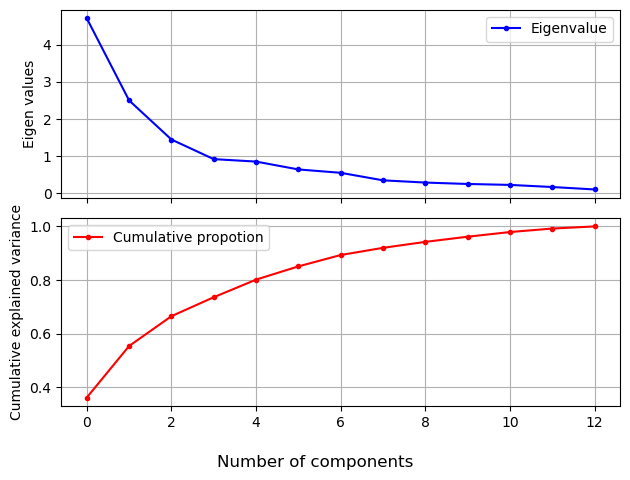

In [13]:
# Nhận xét: Đồ thị scree khá thoải, 
# dẫn đến việc ta cần nhiều trị riêng/vector riêng để giữ nhiều thông tin của dữ liệu
screeplot(eigenpairs)

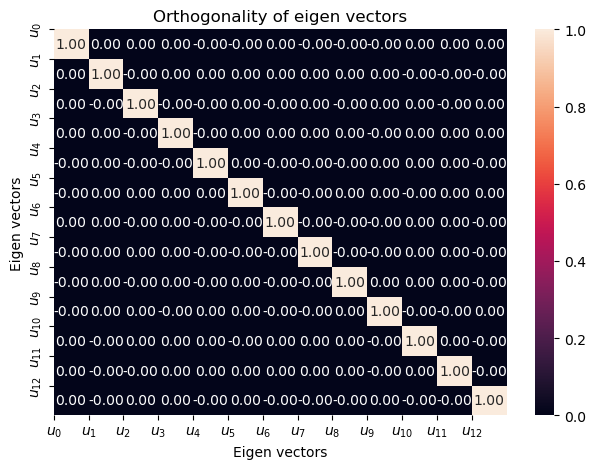

In [14]:
import seaborn as sns
# Kiểm chứng sự trực chuẩn của họ các vector riêng
# Sự trực chuẩn này có được là nhờ sử dụng hàm np.linalg.eigh

# chọn các vector riêng từ danh sách các cặp trị riêng-vector riêng
eigenvecs = np.array([eigenvec for (_, eigenvec) in eigenpairs]) 

# Ma trận chứa các giá trị tích vô hướng của từng cặp vector riêng.
# eg: table[i,j] = u_i.T @ u_j
table = np.zeros((len(eigenvecs), len(eigenvecs)))

# labels
labels = [f'$u_{{{i}}}$' for i in range(len(eigenvecs))]

fig, ax = plt.subplots()

# Tính dot-product của từng cặp vector riêng `u_i.T @ u_j`
for i, vec_x in enumerate(eigenvecs):
    for j, vec_y in enumerate(eigenvecs):
        table[i, j] = vec_x.T.dot(vec_y)

sns.heatmap(table, annot=True, fmt='.2f', ax=ax)

ax.set(xlabel='Eigen vectors', 
       ylabel='Eigen vectors', 
       title='Orthogonality of eigen vectors', 
       xticks=np.arange(len(eigenvecs)),
       yticks=np.arange(len(eigenvecs)),
       xticklabels=labels,
       yticklabels=labels)

plt.tight_layout()
plt.show()

In [15]:
print(eigenvecs.shape)
print(eigenvecs)

(13, 13)
[[-0.1443294   0.24518758  0.00205106  0.23932041 -0.14199204 -0.39466085
  -0.4229343   0.2985331  -0.31342949  0.0886167  -0.29671456 -0.37616741
  -0.28675223]
 [ 0.48365155  0.22493093  0.31606881 -0.0105905   0.299634    0.06503951
  -0.00335981  0.02877949  0.03930172  0.52999567 -0.27923515 -0.16449619
   0.36490283]
 [ 0.20738262 -0.08901289 -0.6262239  -0.61208035 -0.13075693 -0.14617896
  -0.1506819  -0.17036816 -0.14945431  0.13730621 -0.08522192 -0.16600459
   0.12674592]
 [-0.0178563   0.53689028 -0.21417556  0.06085941 -0.35179658  0.19806835
   0.15229479 -0.20330102  0.39905653  0.06592568 -0.42777141  0.18412074
  -0.23207086]
 [-0.26566365  0.03521363 -0.14302547  0.06610294  0.72704851 -0.14931841
  -0.10902584 -0.50070298  0.13685982 -0.07643678 -0.17361452 -0.10116099
  -0.1578688 ]
 [-0.21353865 -0.53681385 -0.15447466  0.10082451 -0.03814394  0.0841223
   0.01892002  0.25859401  0.53379539  0.41864414 -0.10598274 -0.26585107
  -0.11972557]
 [ 0.05639636 

In [16]:
# Cần 10 vector thành phần chính ta mới có thể giữ lại 95% thông tin của dữ liệu
find_num_pc(eigenpairs, thres = 0.95)

10

In [17]:
# Ta chỉ giữ lại 55% dữ liệu khi lấy 2 vector thành phần chính
eigenvals = [eigenval for (eigenval, _) in eigenpairs]
eigenvals = np.array(eigenvals)
# 2) Tính tổng tích lũy các trị riêng
# eg: [0.2, 0.3, 0.4] -> [0.2, 0.5, 0.9]
cumsum = np.cumsum(eigenvals)
# 3) Tính phần trăm phương sai giải thích (explained variance ratio)
# cho các thành phần chính
cumsum /= cumsum[-1]

cumsum[1]

0.5540633835693526

In [18]:
cumsum

array([0.36198848, 0.55406338, 0.66529969, 0.73598999, 0.80162293,
       0.85098116, 0.89336795, 0.92017544, 0.94239698, 0.96169717,
       0.97906553, 0.99204785, 1.        ])

In [19]:
# Để dễ trực quan, ta sẽ dùng 2 vector, tức chỉ giữ lại 55% thông tin của dữ liệu
W = construct_W(eigenpairs[:2])

In [20]:
X_proj_eig = W.dot(X_std.T)
X_proj_eig = X_proj_eig.T

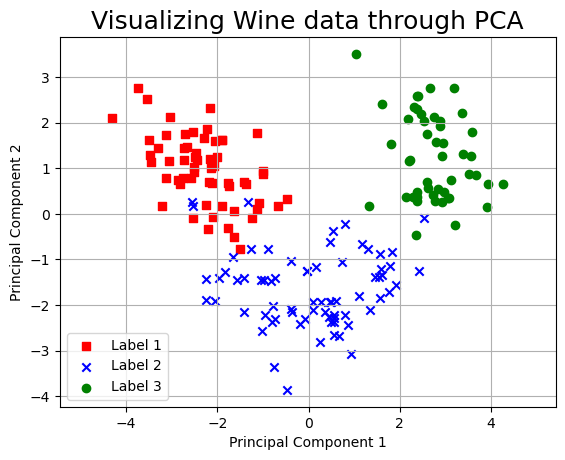

In [21]:
colors = ['r', 'b', 'g'] # màu hiển thị, tương ứng red, blue, green
markers = ['s', 'x', 'o'] # marker cho mỗi label 

fig, ax = plt.subplots()

for l, c, m in zip(np.unique(y), colors, markers):
    ax.scatter(X_proj_eig[y == l, 0], X_proj_eig[y == l, 1], c = c, label = f'Label {l}', marker = m)
    # ax.scatter(X_proj_eig[y == l, 0], X_proj_eig[y == l, 1], label = f'Label {l}')
    
ax.set(xlabel = 'Principal Component 1', ylabel = 'Principal Component 2')
plt.title('Visualizing Wine data through PCA', fontsize=18)
plt.legend(loc='lower left')
plt.gca().set_aspect('equal', 'datalim')
plt.grid()
plt.show()

## PCA với Singular Value Decomposition

Cho ma trận $\textbf{X} \in \mathbb{R}^{N\times d}$. Khi đó, ma trận $\textbf{X}$ có thể được viết dưới dạng:
$$
\textbf{X} = \textbf{USV}^T
$$
trong đó: 
- $\textbf{U} \in \mathbb{R}^{N\times N}, \textbf{V} \in \mathbb{R}^{N\times d}$ là các ma trận trực giao sao cho $\textbf{U}^T \textbf{U} = \textbf{I}_N, \textbf{V}^T \textbf{V} = \textbf{I}_d$ và $\textbf{S} \in \mathbb{R}^{N\times N}$ là ma trận đường chéo.
- $\textbf{U}$ là ma trận chứa các cột (column) được gọi là `left-singular vectors` được tạo bởi các vector riêng của $\textbf{X}\textbf{X}^T$.
- $\textbf{V}$ là ma trận chứa các cột (column) được gọi là `right-singular vectors` được tạo bởi các vector riêng của $\textbf{X}^T\textbf{X}$.
- $\textbf{S}$ là ma trận đường chéo chứa các singular values $s_i$

In [22]:
# SVD 
U, S, Vh = np.linalg.svd(X_std)

# Chiếu dữ liệu lên 2 thành phần chính đầu tiên.
X_proj_svd = X_std @ Vh[:2].T

In [23]:
# So sánh kết quả với thuật toán sử dụng Eigendecomposition.
np.allclose(X_proj_svd, X_proj_eig) # i.e X_proj_svd[i,j] == X_proj_eig[i,j], với mọi i,j

True

Kiểm chứng công thức $\lambda_i = \displaystyle \frac{s_i^2}{N-1}$. 

Xem thêm: https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca/134283#134283

In [24]:
np.allclose((S**2)/(N-1), eigenvals)

True

In [25]:
print((S**2)/(N-1)) # singular-values
print(eigenvals) # lambdas (eigen-values)

[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.28887994 0.25090248 0.22578864 0.16877023
 0.10337794]
[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.28887994 0.25090248 0.22578864 0.16877023
 0.10337794]


## So sánh với hàm thư viện

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)

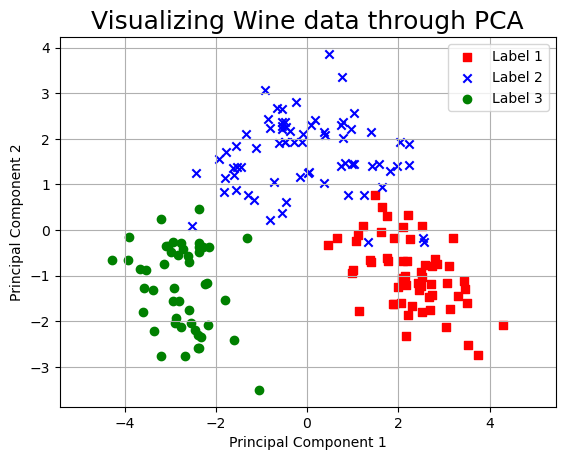

In [27]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

fig, ax = plt.subplots()

for l, c, m in zip(np.unique(y), colors, markers):
    ax.scatter(X_pca[y == l, 0], X_pca[y == l, 1], c = c, label = f'Label {l}', marker = m)
    
ax.set(xlabel = 'Principal Component 1', ylabel = 'Principal Component 2')
plt.title('Visualizing Wine data through PCA', fontsize=18)
plt.legend(loc='best',)
plt.gca().set_aspect('equal', 'datalim')
plt.grid()
plt.show()

In [28]:
print(">> Eigen vectors (from scratch): \n", eigenvecs[:2])
print("\n>> Eigen vectors (from scikit-learn): \n", pca.components_)

>> Eigen vectors (from scratch): 
 [[-0.1443294   0.24518758  0.00205106  0.23932041 -0.14199204 -0.39466085
  -0.4229343   0.2985331  -0.31342949  0.0886167  -0.29671456 -0.37616741
  -0.28675223]
 [ 0.48365155  0.22493093  0.31606881 -0.0105905   0.299634    0.06503951
  -0.00335981  0.02877949  0.03930172  0.52999567 -0.27923515 -0.16449619
   0.36490283]]

>> Eigen vectors (from scikit-learn): 
 [[ 0.1443294  -0.24518758 -0.00205106 -0.23932041  0.14199204  0.39466085
   0.4229343  -0.2985331   0.31342949 -0.0886167   0.29671456  0.37616741
   0.28675223]
 [-0.48365155 -0.22493093 -0.31606881  0.0105905  -0.299634   -0.06503951
   0.00335981 -0.02877949 -0.03930172 -0.52999567  0.27923515  0.16449619
  -0.36490283]]


# 2. PCA for Noise Filtering

PCA can also be used to filter unwanted noise from the data. The idea behind this concept is that components which have variance higher than that of noise should remain reasonably affected by noise. Thus if we reconstruct the data with only the largest group of principal components, we can easily filter out the noise from our data

In [29]:
mnist = pd.read_csv('https://raw.githubusercontent.com/hduc-le/Introduction-to-data-science/main/datasets/mnist_train_small.csv', header=None)
mnist.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Setting the label and the feature columns
y = mnist.loc[:,0].values
x = mnist.loc[:,1:].values

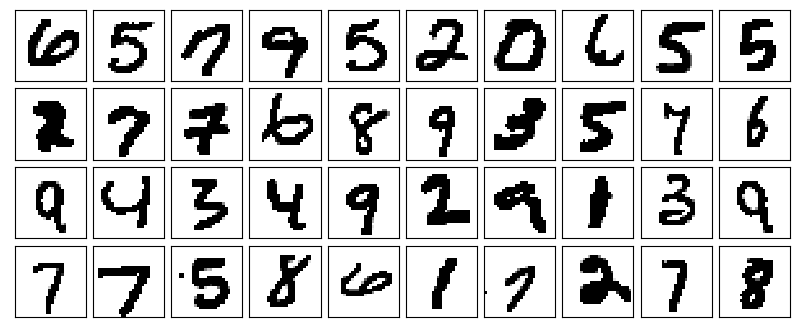

In [31]:
## Plotting the original train data without noise

def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        
plot_digits(x)

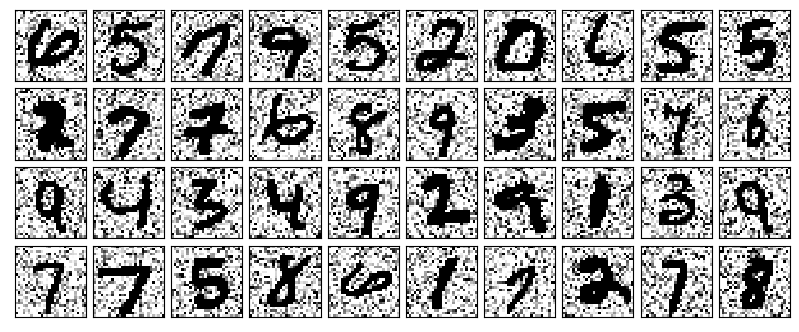

In [32]:
## Introducing some random noise

np.random.seed(42)
noisy = np.random.normal(x, 10) # noisy ~ N(x,10)
plot_digits(noisy)

In [33]:
# PCA
from sklearn.decomposition import PCA

# Training a PCA on noisy data and letting the projection preserve 85% of the variance:

pca = PCA(0.85).fit(noisy)

print(">> Num. components that preserve 85% of the variance: ", pca.n_components_)

>> Num. components that preserve 85% of the variance:  67


Here 85% of the variance amounts to 67 (over 784) principal components. Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

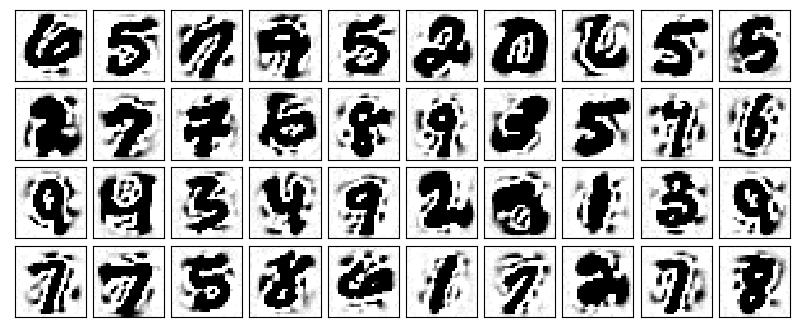

In [34]:
# Using the inverse of the transform to reconstruct the filtered digits:
noisy_proj = pca.transform(noisy)
filtered = pca.inverse_transform(noisy_proj) # X_inv = W.T @ W @ X or X_inv = u[:,:rank], s[:rank], vt[:rank,:]
plot_digits(filtered)

# 3. Low-rank approximation using SVD
Matrix factorization methods have many applications in machine learning. SVD enables us to produce a low-rank approximation of a matrix.

(427, 640)


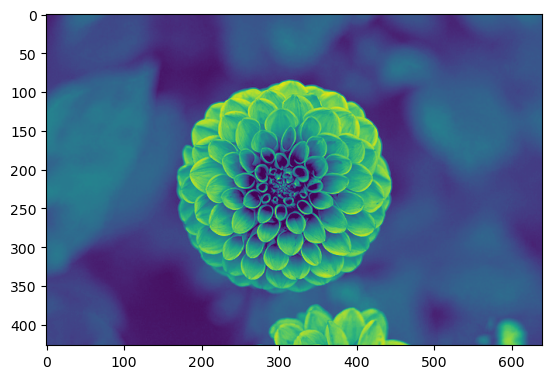

In [35]:
from sklearn.datasets import load_sample_images
dataset = load_sample_images()
first_img_data = dataset.images[1]
x = first_img_data[:,:,1]
print(x.shape)
plt.imshow(x)
plt.show()

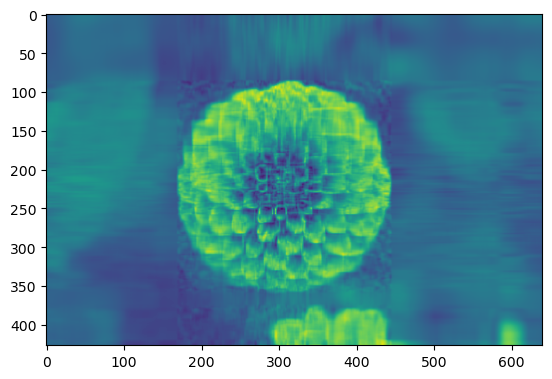

compression: from 273280 to 21340
(427, 640)


In [36]:
u,s,vt = np.linalg.svd(x, full_matrices=False)
#if the shape was x*y now we need to store x*rank + rank*y
rank = 20
uh, sh, vth = u[:,:rank], s[:rank], vt[:rank, :]      #slice the singular values for low dimentional storage
xh = uh @ np.diag(sh) @vth
plt.imshow(xh)
plt.show()
print(f'compression: from {np.prod(x.shape)} to {rank*np.sum(x.shape)}')
print(x.shape)

# 4. Isotropic Gaussian problem
When the sample are (nearly) circular distributed, ie. the eigen values are (nearly) equal, the sample variantion is homogeneous in all directions. It is then not possible to represent the data well in fewer than $d$-dimensions.

When the sample variation is homogeneous in all directions, it means that the covariance matrix of the data is proportional to the identity matrix, which is a diagonal matrix with equal diagonal entries. In other words, all variables in the dataset have the same variance and are uncorrelated with each other.

In this case, the principal components of the data will simply be the original variables themselves, and the variance of the data along each principal component will be equal. In other words, all the principal components will have equal importance and contribute equally to the total variance in the data.

To see why this is the case, consider the covariance matrix of a dataset $\mathbf{X}$ with $d$ variables and $N$ samples:

$\mathbf{S} = \displaystyle\frac{1}{N-1} \mathbf{X}^T \mathbf{X}$

If the variables in $\mathbf{X}$ are uncorrelated and have the same variance, then the covariance matrix $S$ will be proportional to the identity matrix:

$\mathbf{S} = \displaystyle \frac{1}{N-1} \mathbf{X}^T \mathbf{X} = \frac{1}{N-1} \times \mathbf{I}$

The eigenvectors of the covariance matrix $\mathbf{S}$ will be the same as the eigenvectors of the identity matrix $\mathbf{I}$, which are the standard basis vectors. Therefore, the principal components of $\mathbf{X}$ will be the original variables themselves, and the variance explained by each principal component will be equal. In other words, the data is isotropic and the principal components are equally important.

In practice, however, it is rare to encounter datasets where the variables are completely uncorrelated and have exactly the same variance. The PCA algorithm is designed to handle datasets with more complex structures, and can still be used to identify the directions of maximum variance even when the sample variation is not homogeneous in all directions.

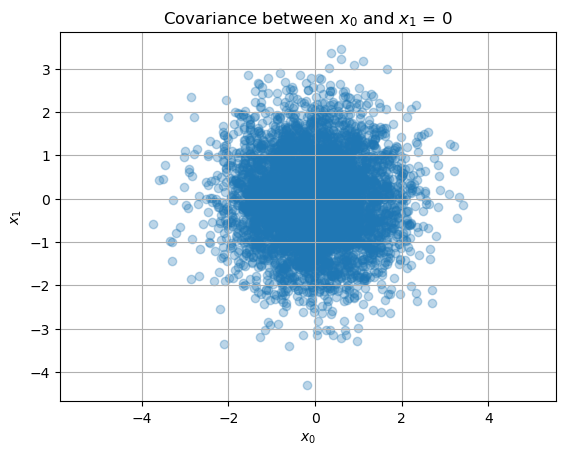

In [37]:
from scipy.stats import multivariate_normal

# Mean vector
mu = [0, 0] 

# Covariance matrix, note that feature x0 and x1 are uncorrelated, 
# i.e: cov[0,1] = cov[1, 0] = 0
cov = [[1, 0], 
       [0, 1]] 

# Define Gaussian distribution with mean=mu and sigma=cov
distr = multivariate_normal(mu, cov)


# Generating 5000 samples out of the distribution
data = distr.rvs(size = 5000)
    
# Plotting the generated samples
# plt.plot(data[:,0], data[:,1], 
#          'o', c='lime', markeredgewidth = 0.5, 
#          markeredgecolor = 'black')
plt.scatter(data[:,0], data[:,1], alpha=.3)

plt.title('Covariance between $x_{0}$ and $x_{1}$ = 0')
plt.xlabel('$x_{0}$')
plt.ylabel('$x_{1}$')
plt.grid()
plt.gca().set_aspect('equal', 'datalim')
plt.show()

In [38]:
# Apply PCA
U, S, Vh = np.linalg.svd(data)

# You can see the singular values are nearly equal
print("Singular values: ", S)

# Hence, PCA cannot perform dimension reduction since both PCs are important. 

Singular values:  [71.33585903 70.08015719]


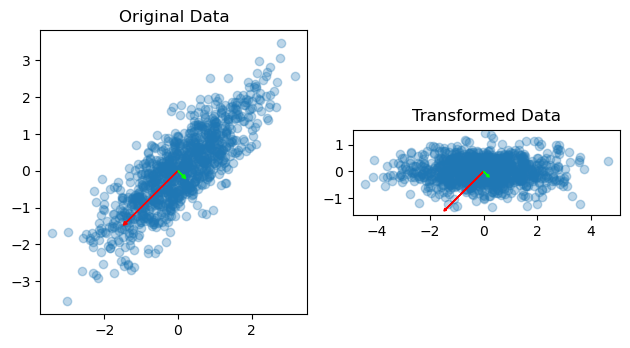

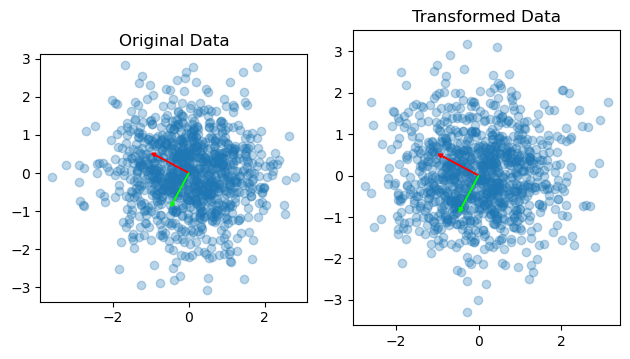

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Define mean vector
mean = [0, 0]

for corr_xy in [0.8, 0.0]:
    # Define the Gaussian distribution
    covariance = [[1, corr_xy], [corr_xy, 1]] # if corr_xy == 0.0, the distribution is an isotropic Gaussian
    data = np.random.multivariate_normal(mean, covariance, 1000)

    # Calculate the eigenvectors and eigenvalues of the covariance matrix
    cov_mat = np.cov(data.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

    # Sort the eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    # Transform the data using the principal components
    transformed_data = np.dot(data, eigenvectors)

    # Plot the original and the transformed data
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs[0].scatter(data[:,0], data[:,1], alpha=0.3)
    axs[0].set_title('Original Data')

    axs[1].scatter(transformed_data[:,0], transformed_data[:,1], alpha=0.3)
    axs[1].set_title('Transformed Data')

    for i in range(2):
        axs[i].arrow(mean[0], mean[1], eigenvectors[0,0]*eigenvalues[0], eigenvectors[1,0]*eigenvalues[0], head_width=0.1, head_length=0.1, fc='r', ec='r')
        axs[i].arrow(mean[0], mean[1], eigenvectors[0,1]*eigenvalues[1], eigenvectors[1,1]*eigenvalues[1], head_width=0.1, head_length=0.1, fc='lime', ec='lime')
        axs[i].set_aspect('equal', 'box')

    plt.tight_layout()
    plt.show()

# Further reading
1. [Making sense of principal component analysis eigenvectors eigenvalues](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

2. [Relationship between SVD and PCA, how to use SVD to perform PCA](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca/134283#134283)

3. [Principal component Analysis with Linear Algebra](https://www.math.union.edu/~jaureguj/PCA.pdf?ref=jeremyjordan.me)

4. [Principal component Analysis tutorial](https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm)

5. Chapter 8. [Johnson, R. A., Wichern, D. W. (2002). Applied multivariate statistical analysis. Upper Saddle River, NJ: Prentice Hall. ISBN: 0130925535](https://ostad.hormozgan.ac.ir/ostad/UploadedFiles/863845/97050509-3761826667770356.pdf)

6. Chapter 12.1. [Bishop, Christopher M. (2006). Pattern recognition and machine learning. New York :Springer,](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)